## Using the  Super Resolution convolutional Neural Network for Image Restoration 
We propose a depp learning method for single image super resolution(SR). Our method directly learns an end-to end mapping between the low/high resolution images. The mapping is represented as a deep convolutional neural network (CNN) that takes the low-resolution image as the input and outputs the high-resolution one. We further show that traditional sparse-coding-based SR methods can also be viewed as a deep convolutional network. But unlike traditional methods that handle each component separately, our method jointly optimizes all layers. Our deep CNN has a lightweight structure. yet demonstrates state-of-the-art restoration quality, and achieves fast speed for practical on-line usage. We explore different network structures and parameter settings to achieve trade-offs between performance and speed. Moreover, we extend our network to cope with three color channels simultaneously, and show
better overall reconstruction quality.

As the title suggests the SRCNN is a deep convolutiorul neural network that learns end-to-end mapping of low resolution to high resolution images As a result we can use it to improve image quality of low resolution images. To evaluate the performance of this network. we will be using three image quality metrics: peak signal to noise ratio (PSNR) means squared error (MSE), and the structural similarity (SSIM) index.


1. Use the PSNR, MSE and SSIM image quality metrics
2. process image using OpenCv
3. convert between the RGB, BGR and YcrCb color spaces
4. build deep neural networks in Keras
5. deploy and evaluate the SRCNN network

In [2]:
import os


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.optimizers import SGD, Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [4]:
# define a function for peak signal to noise ration (PSNR)

def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff **2.))
    return 20 * math.log10(255./rmse)

def mse(target, ref):
    err = np.sum((target.astype('float')- ref.astype('float'))**2)
    err /= float(target.shape[0]*target.shape[1])
    return err

def compare_image(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, win_size=3, channel_axis=-1)) 
    return scores

In [5]:
def prepare_images(path, factor, quality = 100):
    # loop thrught the files in the directory
    for file in os.listdir(path):
        # open the file
        image = cv2.imread(path + '/' + file)
        # find the old and new image dimensions
        h, w, c = image.shape
        new_h, new_w = int(h / factor), int(w /factor)
        # resize the image - down
        image = cv2.resize(image, (new_w, new_h), interpolation= cv2.INTER_CUBIC)
        # resize the image - up
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_CUBIC)
        # save he image
        output_dir = 'LR2'
        os.makedirs(output_dir, exist_ok=True) 
        output_path = os.path.join(output_dir, file)
        print(f"Saving {output_path} with quality={quality}")
        cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, quality])

In [6]:
# def prepare_images(path, factor):
#     # loop thrught the files in the directory
#     for file in os.listdir(path):
#         # open the file
#         image = cv2.imread(path + '/' + file)
#         # find the old and new image dimensions
#         h, w, c = image.shape
#         new_h, new_w = int(h / factor), int(w /factor)
#         # resize the image - down
#         image = cv2.resize(image, (new_w, new_h), interpolation= cv2.INTER_LINEAR)
#         # resize the image - up
#         image = cv2.resize(image, (w, h), interpolation = cv2.INTER_LINEAR)
#         # save he image
#         print("Saving {}".format(file))
#         output_dir = 'data/degraded'
#         os.makedirs(output_dir, exist_ok=True) 
#         output_path = os.path.join(output_dir, file)
#         cv2.imwrite(output_path, image)

In [ ]:
# prepare_images('HR1', 4)  

In [8]:
# testing the generated images using the image quality metrics

for file in os.listdir('LR2/'):
    target = cv2.imread('LR2/{}'.format(file))
    ref = cv2.imread('HR1/{}'.format(file))
    
    # calculate the scores
    # scores = compare_image(target, ref)
    # print(f"{file} \nPSNR: {scores[0]}\n MSE : {scores[1]}\nSSIM : {scores[2]}")

In [9]:
target.shape

(512, 512, 3)

In [10]:
ref.shape

(512, 512, 3)

In [11]:
# define the SRCNN model
def model():
    # define model type
    SRCNN = Sequential()
    # add model layers
    SRCNN.add(Conv2D(filters = 128, kernel_size=  (9,9), kernel_initializer= 'glorot_uniform', activation = 'relu', padding = 'valid', use_bias = True, input_shape = (None, None, 1)))   
    SRCNN.add(Conv2D(filters = 64, kernel_size = (3,3), kernel_initializer='glorot_uniform', activation = 'relu', padding = 'same', use_bias = True))
    SRCNN.add(Conv2D(filters = 1, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation = 'linear', padding = 'valid', use_bias = True))
    
    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    SRCNN.compile(optimizer = adam, loss= 'mean_squared_error', metrics = ['mean_squared_error'])
    return SRCNN

In [12]:
# define necessary image processing functions
def modcrop(img, scale):
    h, w = img.shape[:2]
    h = h - (h % scale)  # Ensure divisibility
    w = w - (w % scale)
    return img[:h, :w]


def shave(image, border):
    img = image[border : -border, border : -border]
    return img
    

In [20]:
# define main predication function
def predict(image_path):
    srcnn = model()
    srcnn.load_weights('models/3051crop_weight_200.h5')
    
    # load the degraded and refernce images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(f'LR2/{file}')
    degraded_dummy = cv2.imread(image_path)
    ref = cv2.imread(f'HR1/{file}')
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    degraded_dummy = modcrop(degraded_dummy, 3)
    
    #convert the image to YCrCb (red diff, blue diff) - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype = float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn 
    pre = srcnn.predict(Y)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    #copy Y channel back tom image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    # remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    degraded_dummy = shave(degraded_dummy.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_image(degraded_dummy, ref))
    scores.append(compare_image(output, ref))
    
    return ref, degraded, output, scores

In [14]:
import tensorflow as tf

In [21]:
ref, degraded, output, scores = predict('LR3/im1008.jpg')
print(f"Degraded Image : \nPSNR: {scores[0][0]}\n MSE : {scores[0][1]}\nSSIM : {scores[0][2]}")
print(f"Reconstructed Image : \nPSNR: {scores[1][0]}\n MSE : {scores[1][1]}\nSSIM : {scores[1][2]}")


1/1 [==============================] - 0s 156ms/step
Degraded Image : 
PSNR: 23.10708517886801
 MSE : 953.8785826035064
SSIM : 0.7133199717414201
Reconstructed Image : 
PSNR: 26.103878990179595
 MSE : 478.4248358897437
SSIM : 0.7922691674765326


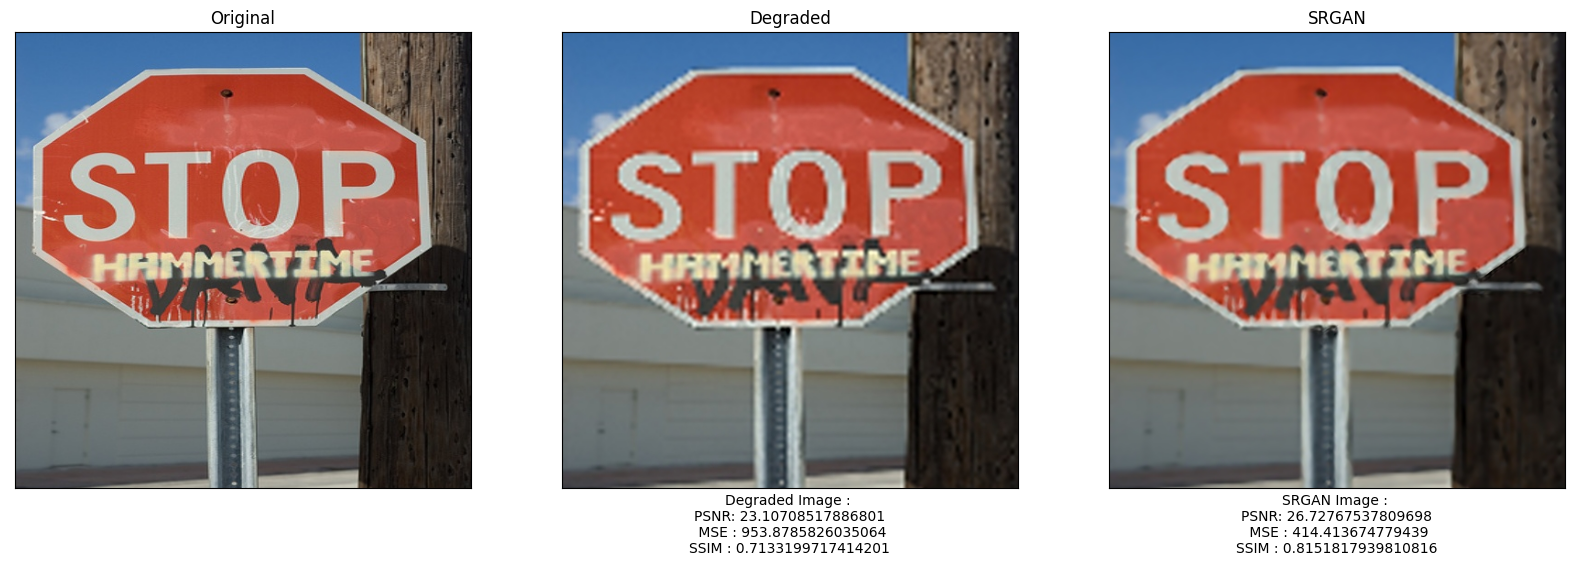

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[1].set(xlabel = f'Degraded Image : \nPSNR: {scores[0][0]}\n MSE : {scores[0][1]}\nSSIM : {scores[0][2]}')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRGAN') 
axs[2].set(xlabel = f'SRGAN Image : \nPSNR: {scores[1][0]}\n MSE : {scores[1][1]}\nSSIM : {scores[1][2]}')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    

In [17]:
from tqdm import tqdm 

In [22]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

input_folder = 'LR3/'
output_folder = 'output_top20/'
os.makedirs(output_folder, exist_ok=True)

# Step 1: Collect all scores without saving plots yet
results = []  # (filename, ref, degraded, output, scores)
count = 0
for file in tqdm(os.listdir(input_folder), desc="Collecting Scores"):
    if count > 100: 
        break
    count +=1
    if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(input_folder, file)
    ref, degraded, output, scores = predict(img_path)

    results.append((file, ref, degraded, output, scores))

top_100 = sorted(results, key=lambda x: x[4][1][0], reverse=True)[:100]
total_psnr = sum(scores[1][0] for _, _, _, _, scores in top_100)
total_ssim = sum(scores[1][2] for _, _, _, _, scores in top_100)

average_psnr = total_psnr / len(top_100)
average_ssim = total_ssim / len(top_100)

print(f"\nAverage PSNR of Top 100 SRGAN Output Images: {average_psnr:.2f} dB")
print(f"Average SSIM of Top 100 SRGAN Output Images: {average_ssim:.4f}")
# Step 3: Save only top 20 images with metrics
# for file, ref, degraded, output, scores in top_20:
#     fig, axs = plt.subplots(1, 3, figsize=(20, 8))

#     axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
#     axs[0].set_title('Original')

#     axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
#     axs[1].set_title('Degraded')
#     axs[1].set(xlabel=f"PSNR: {scores[0][0]:.2f}\nMSE: {scores[0][1]:.4f}\nSSIM: {scores[0][2]:.4f}")

#     axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
#     axs[2].set_title('SRGAN Output')
#     axs[2].set(xlabel=f"PSNR: {scores[1][0]:.2f}\nMSE: {scores[1][1]:.4f}\nSSIM: {scores[1][2]:.4f}")

#     for ax in axs:
#         ax.set_xticks([])
#         ax.set_yticks([])

#     output_filename = os.path.splitext(file)[0] + ".png"
#     fig.savefig(os.path.join(output_folder, output_filename))
#     plt.close(fig)

#     print(f"Saved top image: {output_folder}{output_filename}")


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 166ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 228ms/step


1/1 [==============================] - 0s 196ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 171ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 224ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 215ms/step



Average PSNR of Top 100 SRGAN Output Images: 26.27 dB
Average SSIM of Top 100 SRGAN Output Images: 0.7554
